In [1]:
BASE_DIR = '/content/drive/MyDrive/rooftop_detection/'
DATA_DIR = f'{BASE_DIR}malaysia_kuala_lumpur_dataset_final/'
print(DATA_DIR)

/content/drive/MyDrive/rooftop_detection/malaysia_kuala_lumpur_dataset_final/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import library**

In [3]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.autograd import Variable

from PIL import Image
import numpy as np
import glob
import os
import albumentations
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0")

**Analyze dataset**

In [4]:
class RooftopDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_file = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
        self.mask_file = sorted(glob.glob(os.path.join(mask_dir, '*.jpg')))
        print(len(self.image_file))
        print(len(self.mask_file))

    def __len__(self):
        return len(self.image_file)

    def __getitem__(self, index):
        image = np.array(Image.open(self.image_file[index]).convert("RGB"))
        mask = np.array(Image.open(self.mask_file[index]).convert("L"), dtype=np.float32)
        mask[mask > 0.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image, mask


**Load dataset**

In [8]:
train_image_folder = f'{DATA_DIR}train/images'
train_mask_folder = f'{DATA_DIR}train/labels'

test_image_folder = f'{DATA_DIR}test/images'
test_mask_folder = f'{DATA_DIR}test/labels'

transform_train = albumentations.Compose([
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    albumentations.Rotate(limit=35, p=1.0),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.1),
    albumentations.pytorch.ToTensor()
])

transform = albumentations.Compose([
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    albumentations.pytorch.ToTensor()
])

train_set = RooftopDataset(train_image_folder, train_mask_folder, transform)
test_set = RooftopDataset(test_image_folder, test_mask_folder, transform)

train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

print(train_set[0][0].size(), train_set[0][1].size())
print(len(train_loader), len(test_loader))

717
717
70
70
torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
359 70


**Preview dataset**

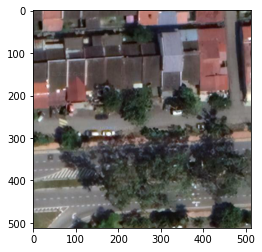

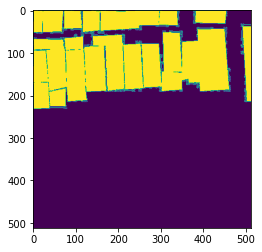

In [9]:
img, label = train_set[0]
img = img.swapaxes(0,1)
img = img.swapaxes(1,2)
plt.imshow(img)
plt.show()
label = label.swapaxes(0,1)
label = label.swapaxes(1,2)
plt.imshow(label[:,:,0])
plt.show()


**Build UNET**

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

**Build DABENET**

In [11]:
class Recurrent_Block(nn.Module):
    def __init__(self, out_channels):
        super(Recurrent_Block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
		    nn.BatchNorm2d(out_channels),
		    nn.ReLU(inplace=True)
        )

    def forward(self,x):
        out = self.conv(x)
        for _ in range(2):
            out = self.conv(x + out)
        return out

class SERRCNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SERRCNN_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.rrcnn = nn.Sequential(
            Recurrent_Block(out_channels),
            Recurrent_Block(out_channels)
        )
        self.squeeze_and_excitation = torchvision.ops.SqueezeExcitation(out_channels, out_channels // 16)

    def forward(self, x):
        x = self.conv(x)
        out = self.rrcnn(x)
        out = self.squeeze_and_excitation(out)
        out = out + x
        return out

class Attention_Gate(nn.Module):
    def __init__(self,in_channels_g, in_channels_l, out_channels):
        super(Attention_Gate,self).__init__()
        self.conv_g = nn.Sequential(
            nn.Conv2d(in_channels_g, out_channels, kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(out_channels)
        )
        self.conv_x = nn.Sequential(
            nn.Conv2d(in_channels_l, out_channels, kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.ReLU(inplace=True)
        self.psi = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, g, x):
        g_out = self.conv_g(g)
        x_out = self.conv_x(x)
        psi = self.relu(g_out + x_out)
        psi = self.psi(psi)
        return x * psi

class DABE_NET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(DABE_NET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
  
        for feature in features:
            self.downs.append(SERRCNN_Block(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(SERRCNN_Block(feature*2, feature))
            self.attentions.append(Attention_Gate(feature, feature, feature//2))

        self.bottleneck = SERRCNN_Block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1,stride=1,padding=0)
    
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = self.attentions[idx//2](x, skip_connection)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

**Lovasz Hinge Loss**

In [12]:
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1.0 - gt_sorted).float().cumsum(0)
    jaccard = 1.0 - intersection / union
    if p > 1:
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels):
    loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels))
    return loss

def lovasz_hinge_flat(logits, labels):
    signs = 2.0 * labels.float() - 1.0
    errors = 1.0 - logits * Variable(signs)
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

def flatten_binary_scores(scores, labels, ignore=None):
    scores = scores.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def symmetric_lovasz(outputs, targets):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

class LovaszLossHinge(nn.Module):
    def __init__(self):
        super(LovaszLossHinge, self).__init__()

    def forward(self, input, target):
        loss = lovasz_hinge(input, target)
        return loss

**Measure Unit**

In [13]:
import math
def iou(pred, target):
    if np.all(target == 0):
        target = 1 - target
        pred = 1 - pred
    intersection = np.logical_and(pred, target)
    union = np.logical_or(pred, target)
    result = np.sum(intersection)/np.sum(union)
    if math.isnan(result): result = 0
    return result

def accuracy(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    TN = np.sum(np.logical_and(pred == 0, target == 0))
    FP = np.sum(np.logical_and(pred == 1, target == 0))
    FN = np.sum(np.logical_and(pred == 0, target == 1))
    if (TP + FP + TN + FN) == 0: return 0
    else: return (TP + TN)/(TP + FP + TN + FN)
  
def recall(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    FN = np.sum(np.logical_and(pred == 0, target == 1))
    if (TP + FN) == 0: return 0
    else: return TP/(TP + FN)

def precision(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    FP = np.sum(np.logical_and(pred == 1, target == 0))
    if (TP + FP) == 0: return 0
    else: return TP/(TP + FP)

def f1_score(pred, target):
    TP = np.sum(np.logical_and(pred == 1, target == 1))
    FP = np.sum(np.logical_and(pred == 1, target == 0))
    FN = np.sum(np.logical_and(pred == 0, target == 1))
    if (2*TP + FP + FN) == 0: return 0
    else: return 2*TP/(2*TP + FP + FN)

**Train epoch**

In [14]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)
    model.train()
    running_loss = []
    for batch_idx, (image, mask) in enumerate(loop):
        image = image.to(device)
        mask = mask.float().to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predict = model(image)
            loss = loss_fn(predict, mask)
            loss.backward()
            running_loss.append(loss.item())
            optimizer.step()
        loop.set_postfix(last_loss=loss.item())
    print()    
    print(f"average_loss={np.mean(running_loss):.4f}", end="")

**Test epoch**

In [15]:
def test_fn(loader, model, device):
    with torch.no_grad():
        running_iou = []
        running_accuracy = []
        running_recall = []
        running_precision = []
        running_f1_score = []
        model.eval()
        for batch_idx, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)

            for i in range(images.shape[0]):
                prediction = torch.sigmoid(model(torch.unsqueeze(images[i], 0)))
                preds = (prediction > 0.5).float().detach().cpu().numpy()
                mask = labels[i].detach().cpu().numpy()
                running_iou.append(iou(preds, mask))
                running_accuracy.append(accuracy(preds, mask))
                running_recall.append(recall(preds, mask))
                running_precision.append(precision(preds, mask))
                running_f1_score.append(f1_score(preds, mask))

    print(f"precision= {np.mean(running_precision):.4f}, recall={np.mean(running_recall):.4f}, "
          f"f1_score={np.mean(running_f1_score):.4f}, accuracy={np.mean(running_accuracy):.4f}, "
          f"iou={np.mean(running_iou):.4f}")
    return (np.mean(running_iou), np.mean(running_accuracy))
    

**Train Baseline model (UNET)**

In [16]:
model_baseline = UNET(in_channels=3, out_channels=1).to(device)
loss_fn_baseline = symmetric_lovasz
optimizer = optim.Adam(params=model_baseline.parameters(), lr=0.0001)

best_iou_baseline = 0

for epoch in range(10):
    print('Epoch', epoch)   
    train_fn(train_loader, model_baseline, optimizer, loss_fn_baseline)
    out_iou, out_acc = test_fn(test_loader, model_baseline, device)
    best_iou_baseline = max(best_iou_baseline, out_iou)

print(f"best_iou={best_iou_baseline:.4f}")   

Epoch 0


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=0.841]


average_loss=0.7060

precision= 0.8207, recall=0.7393, f1_score=0.7632, accuracy=0.8717, iou=0.6429
Epoch 1


100%|██████████| 359/359 [01:21<00:00,  4.39it/s, last_loss=0.752]


average_loss=0.5664

precision= 0.7985, recall=0.8307, f1_score=0.7999, accuracy=0.8812, iou=0.6899
Epoch 2


100%|██████████| 359/359 [01:21<00:00,  4.40it/s, last_loss=0.645]


average_loss=0.5385

precision= 0.7587, recall=0.8417, f1_score=0.7840, accuracy=0.8720, iou=0.6724
Epoch 3


100%|██████████| 359/359 [01:21<00:00,  4.40it/s, last_loss=0.65]


average_loss=0.5214

precision= 0.7927, recall=0.7254, f1_score=0.7433, accuracy=0.8705, iou=0.6271
Epoch 4


100%|██████████| 359/359 [01:21<00:00,  4.41it/s, last_loss=0.277]


average_loss=0.5066

precision= 0.8297, recall=0.7927, f1_score=0.7989, accuracy=0.8920, iou=0.6903
Epoch 5


100%|██████████| 359/359 [01:21<00:00,  4.41it/s, last_loss=0.887]


average_loss=0.4985

precision= 0.8363, recall=0.7782, f1_score=0.7884, accuracy=0.8881, iou=0.6804
Epoch 6


100%|██████████| 359/359 [01:21<00:00,  4.41it/s, last_loss=0.393]


average_loss=0.4998

precision= 0.8334, recall=0.7722, f1_score=0.7827, accuracy=0.8824, iou=0.6692
Epoch 7


100%|██████████| 359/359 [01:21<00:00,  4.40it/s, last_loss=0.443]


average_loss=0.4707

precision= 0.7662, recall=0.8522, f1_score=0.7951, accuracy=0.8805, iou=0.6875
Epoch 8


100%|██████████| 359/359 [01:21<00:00,  4.41it/s, last_loss=0.37]


average_loss=0.4620

precision= 0.8114, recall=0.8315, f1_score=0.8040, accuracy=0.8927, iou=0.6981
Epoch 9


100%|██████████| 359/359 [01:21<00:00,  4.41it/s, last_loss=0.412]


average_loss=0.4506

precision= 0.8285, recall=0.8014, f1_score=0.8027, accuracy=0.8928, iou=0.6972
best_iou=0.6981


**Train model**

In [17]:
model = DABE_NET(in_channels=3, out_channels=1).to(device)
loss_fn = symmetric_lovasz
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

best_iou = 0

for epoch in range(10):
    print('Epoch', epoch)   
    train_fn(train_loader, model, optimizer, loss_fn)
    out_iou, out_acc = test_fn(test_loader, model, device)
    if out_iou > best_iou:
        best_iou = out_iou
        torch.save(model, BASE_DIR + 'out_model.pt')

print(f"best_iou={best_iou:.4f}")

Epoch 0


100%|██████████| 359/359 [04:02<00:00,  1.48it/s, last_loss=0.422]


average_loss=0.6554

precision= 0.6069, recall=0.9125, f1_score=0.7112, accuracy=0.7753, iou=0.5757
Epoch 1


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=0.635]


average_loss=0.5701

precision= 0.6886, recall=0.9100, f1_score=0.7714, accuracy=0.8450, iou=0.6567
Epoch 2


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=0.692]


average_loss=0.5520

precision= 0.7383, recall=0.8734, f1_score=0.7835, accuracy=0.8580, iou=0.6709
Epoch 3


100%|██████████| 359/359 [04:00<00:00,  1.49it/s, last_loss=0.346]


average_loss=0.5399

precision= 0.7323, recall=0.8994, f1_score=0.7939, accuracy=0.8607, iou=0.6836
Epoch 4


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=0.355]


average_loss=0.5183

precision= 0.6565, recall=0.9199, f1_score=0.7539, accuracy=0.8241, iou=0.6312
Epoch 5


100%|██████████| 359/359 [04:00<00:00,  1.49it/s, last_loss=0.857]


average_loss=0.4905

precision= 0.6899, recall=0.8921, f1_score=0.7661, accuracy=0.8402, iou=0.6491
Epoch 6


100%|██████████| 359/359 [04:00<00:00,  1.49it/s, last_loss=0.33]


average_loss=0.4473

precision= 0.6021, recall=0.9358, f1_score=0.7161, accuracy=0.7787, iou=0.5844
Epoch 7


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=1.29]


average_loss=0.4486

precision= 0.5767, recall=0.9429, f1_score=0.6975, accuracy=0.7508, iou=0.5606
Epoch 8


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=0.318]


average_loss=0.4383

precision= 0.4141, recall=0.4096, f1_score=0.3752, accuracy=0.5869, iou=0.2423
Epoch 9


100%|██████████| 359/359 [04:01<00:00,  1.49it/s, last_loss=0.434]


average_loss=0.4464

precision= 0.6565, recall=0.9061, f1_score=0.7443, accuracy=0.8238, iou=0.6196
best_iou=0.6836


**Test some picture**

U-Net

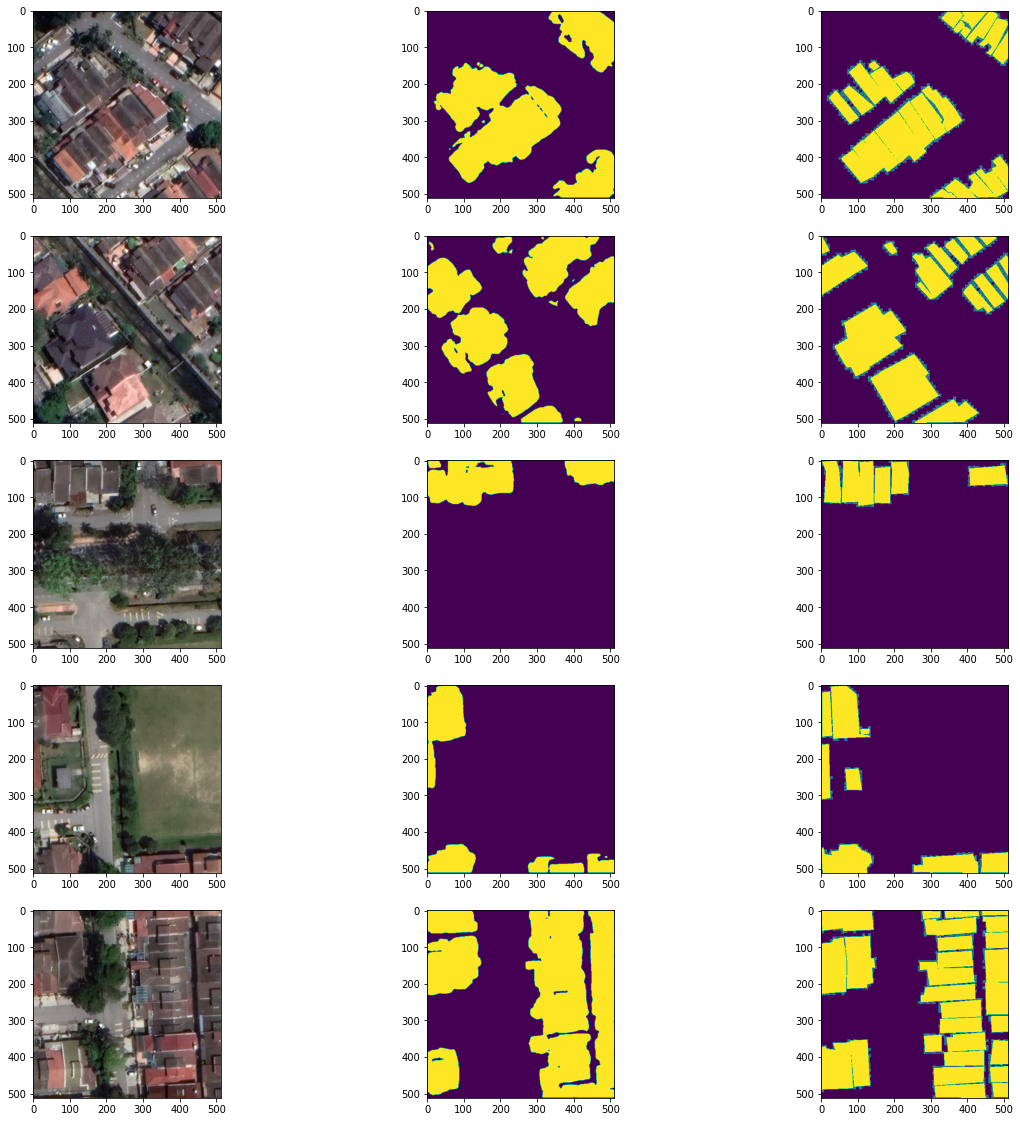

In [18]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))

for img, label in test_loader:
    cnt += 1
    
    #print(img[0].size())
    temp = img[0].swapaxes(0,1)
    temp = temp.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(temp)
   
    
    preds = model_baseline(img.to(device))
    preds = (preds > 0.5).float()
    temp2 = preds[0].swapaxes(0,1)
    temp2 = temp2.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(temp2[:,:,0].cpu().detach().numpy())

    temp1 = label[0].swapaxes(0,1)
    temp1 = temp1.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(temp1[:,:,0])

    if cnt == 5: break
plt.show()    

DABE-Net

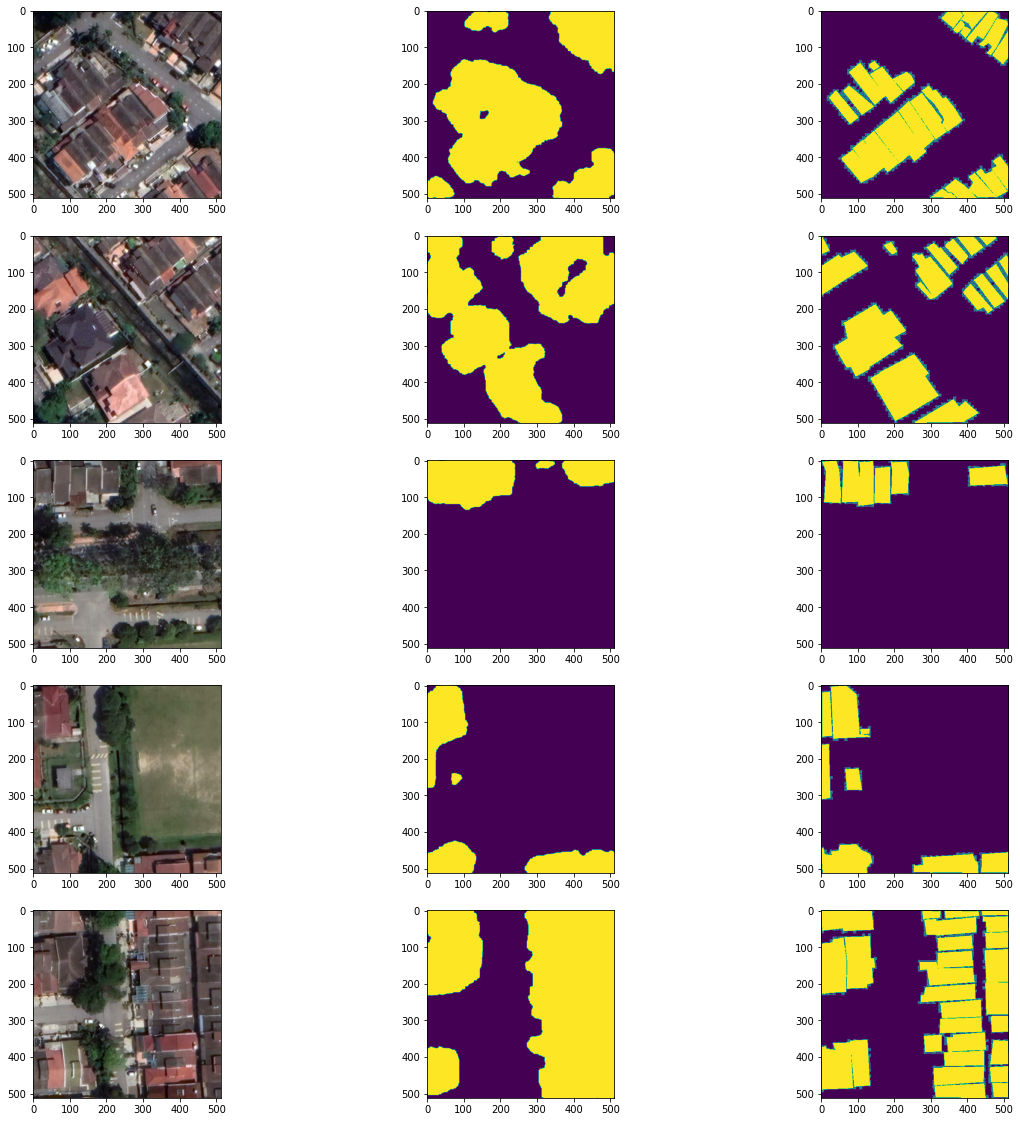

In [19]:
cnt = 0
rows = 5
columns = 3
fig = plt.figure(figsize=(20, 20))
best_model = torch.load(BASE_DIR + 'out_model.pt')
best_model.eval()

for img, label in test_loader:
    cnt += 1
    
    #print(img[0].size())
    temp = img[0].swapaxes(0,1)
    temp = temp.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+1)
    plt.imshow(temp)
   
    
    preds = best_model(img.to(device))
    preds = (preds > 0.5).float()
    temp2 = preds[0].swapaxes(0,1)
    temp2 = temp2.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+2)
    plt.imshow(temp2[:,:,0].cpu().detach().numpy())

    temp1 = label[0].swapaxes(0,1)
    temp1 = temp1.swapaxes(1,2)
    fig.add_subplot(rows, columns, (cnt-1)*3+3)
    plt.imshow(temp1[:,:,0])

    if cnt == 5: break
plt.show()    